In [1]:
import FIM4NTRA
import sys 
import numpy as np

setup= FIM4NTRA.configure(code='serpent', use_matlab =True)


fm = FIM4NTRA.FissionMatrix(r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\FIM4NTRAcode\FA25_600K_fmtx0.m")


In [22]:
def generate_ifc_file(T_distribution,material_name: str, reference_density: float,  nx_xmin_xmax: list, ny_ymin_ymax: list, nz_zmin_zmax: list, density_function = None ):
    
    """
    Generate an IFC (Input File for Calculations) for a material, specifying the temperature and density distribution.

    Parameters:
    - material_name (str): Name of the material.
    - reference_density (float): Reference density for the material.
    - nx_xmin_xmax (list): [nx, xmin, xmax] for the x-dimension.
    - ny_ymin_ymax (list): [ny, ymin, ymax] for the y-dimension.
    - nz_zmin_zmax (list): [nz, zmin, zmax] for the z-dimension.
    - density_function (Callable, optional): User-defined function to compute density distribution.
    """


    # Using user-defined relation (function) to generate density distribution.
    if density_function is not None: 
        rho_distribution = density_function(T_distribution)
    else:
        rho_distribution = np.ones_like(T_distribution)*reference_density
    
    
    # Valori fissi del modello TREAT
    XMIN, XMAX = nx_xmin_xmax[1], nx_xmin_xmax[2] 
    YMIN, YMAX = ny_ymin_ymax[1], ny_ymin_ymax[2] 
    ZMIN, ZMAX = nz_zmin_zmax[1], nz_zmin_zmax[2]

    # Corregge il primo valore di Tdist per il bug TMS di Serpent
    T_distribution[0] += 0.001

    # Apre il file in modalità scrittura
    with open(f"{material_name}.ifc", 'w', newline='\n') as file:
        # Prima linea: TYPE MAT OUT
        file.write(f"2 {material_name} 0\n")

        # Terza linea: MESHTYPE
        file.write("1\n")

        # Quarta linea: mesh cartesiana con coordinate e dimensioni
        file.write(f"{nx_xmin_xmax[0]} {XMIN:.5f} {XMAX:.5f} {ny_ymin_ymax[0]} {YMIN:.5f} {YMAX:.5f} {nz_zmin_zmax[0]} {ZMIN:.5f} {ZMAX:.5f}\n")

        # Scrive i valori di densità e temperatura in ordine x, y, z
        i = 0
        for iz in range(nz_zmin_zmax[0]):
            for iy in range(ny_ymin_ymax[0]):
                for ix in range(nx_xmin_xmax[0]):
                    file.write(f"{rho_distribution[i]:.6f} {T_distribution[i]:.6f} ")
                    i += 1
                file.write("\n")  # Aggiunge una nuova riga al termine di ogni y-loop

    print(f"File '{material_name}.ifc' successfully created!")

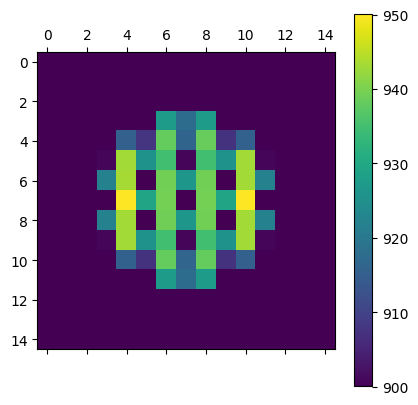

In [30]:
import numpy as np
import matplotlib.pyplot as plt
fs=fm.solve_eigenproblem()[1]

Tmin=900
Tmax=950
fs=fs/np.max(fs)
fs[fs<1E-10]=0.0
Tdist = fs*(Tmax-Tmin)+Tmin
plt.matshow(Tdist)
plt.colorbar()

In [31]:
materials_list = {'UCO_fuel': -10.97 ,
                  'buff_mat': -0.95,
                  'pyC_inner': -1.9,
                  'SiC': -3.18,
                  'graphite': -1.7,
                  'SSA316': -8.0,
                  'SS316':-2.65796 ,
                  'AA6061': -0.0001}
for name,rho in materials_list.items():
    generate_ifc_file(T_distribution=Tdist.flatten(),material_name=name,reference_density=rho,nx_xmin_xmax=[15,-15,15],ny_ymin_ymax=[15,-15,15],nz_zmin_zmax=[1,0.0,1.0])


File 'UCO_fuel.ifc' successfully created!
File 'buff_mat.ifc' successfully created!
File 'pyC_inner.ifc' successfully created!
File 'SiC.ifc' successfully created!
File 'graphite.ifc' successfully created!
File 'SSA316.ifc' successfully created!
File 'SS316.ifc' successfully created!
File 'AA6061.ifc' successfully created!


In [33]:
import numpy as np 
m1 = np.array(
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
)

m2 = np.array(
    [
        [1.5,2.5,3.5],
        [4.5,5,6.5],
        [7.5,8.5,9.5]
    ]
)

m3 = np.array(
    [
        [1.6,2.6,3.6],
        [4.6,5,6.6],
        [7.6,8.6,9.6]
    ]
)

input_m = np.array(
    [
        [1.2,2.5,3.6],
        [4.2,5,6.8],
        [7.5,8.5,10.0]
    ]
)
database = np.array([m1.flatten(),m2.flatten(),m3.flatten()])
dif = database[:,0]-input_m.flatten()[0]
lower = np.min(dif[dif<0])
upper = np.min(dif[dif>0])
print(np.where(dif==upper)[0][0])



#for ima, ma in enumerate([m1.flatten(),m2.flatten(),m3.flatten()]):
#    for iel,elment in enumerate(ma):


1


In [150]:
import numpy as np

def get_adjacent_indices(matrix):
    rows, cols = matrix.shape
    adjacent_matrix = np.empty((rows, cols), dtype=object)

    for i in range(rows):
        for j in range(cols):
            adjacent_indices = []
            # Check all 8 possible directions (N, NE, E, SE, S, SW, W, NW)
            for di, dj in [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < rows and 0 <= nj < cols:
                    adjacent_indices.append((ni, nj))
            adjacent_matrix[i, j] = adjacent_indices

    return adjacent_matrix


m1 = np.array(
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
)

m2 = np.array(
    [
        [1.5,2.5,3.5],
        [4.5,5.1,6.5],
        [7.5,8.5,9.5]
    ]
)

m3 = np.array(
    [
        [1.6,2.6,3.6],
        [4.6,5.1,6.6],
        [7.6,8.6,9.6]
    ]
)

# Esempio di input
input_m = np.array([
    [1.2, 2.55, 3.55],
    [4.55, 5.2, 6.55],
    [7.55, 8.55, 9.55]
])


database = np.array([m1,m2,m3])

dif = database-input_m
adjacent_index_matrix = get_adjacent_indices(input_m)


T_lower = np.zeros_like(input_m)
T_upper = np.zeros_like(input_m)
index_lower = np.zeros_like(input_m)
index_upper = np.zeros_like(input_m)
for i in range(dif.shape[0]):
    for j in range(dif.shape[1]):
        
        if  (len(np.unique(dif[:,i,j])) == len(dif[:,i,j])): #len(dif[:,i,j][dif[:,i,j]<=0])<1 and len(dif[:,i,j][dif[:,i,j]>=0])<1:  
            T_lower[i,j] = np.max(dif[:,i,j][dif[:,i,j]<=0])
            T_upper[i,j] = np.min(dif[:,i,j][dif[:,i,j]>=0])
            #print('lower', dif[:,i,j],np.max(dif[:,i,j][dif[:,i,j]<0]) ,np.where(dif[:,i,j] == np.max(dif[:,i,j][dif[:,i,j]<0])) )
            #print('upper', dif[:,i,j],np.min(dif[:,i,j][dif[:,i,j]>0]) ,np.where(dif[:,i,j] == np.min(dif[:,i,j][dif[:,i,j]>0])) )        
            index_lower[i,j] =np.where(dif[:,i,j] == np.max(dif[:,i,j][dif[:,i,j]<0]))[0]
            index_upper[i,j] =np.where(dif[:,i,j] == np.min(dif[:,i,j][dif[:,i,j]>0]))[0]
        else:
            
            if (len(np.unique(dif[:,i,j][dif[:,i,j]<=0])) != len(dif[:,i,j][dif[:,i,j]<=0])):
                   
                print('need search adjacent function, for lower boundar')
                T_upper[i,j] = np.min(dif[:,i,j][dif[:,i,j]>=0])
                index_upper[i,j] =np.where(dif[:,i,j] == np.min(dif[:,i,j][dif[:,i,j]>0]))[0]

                sum_dif_with_adjacent = np.zeros((dif.shape[0]))

            else:

                print('need search adjacent function, for upper boundar')
                T_lower[i,j] = np.max(dif[:,i,j][dif[:,i,j]<=0])
                index_lower[i,j] =np.where(dif[:,i,j] == np.max(dif[:,i,j][dif[:,i,j]<0]))[0]


            sum_dif_with_adjacent = np.zeros((dif.shape[0]))

            for adjacent_cell in adjacent_index_matrix[i][j]:
                for dataset_index in range(dif.shape[0]): 
                    sum_dif_with_adjacent[dataset_index] += dif[dataset_index][adjacent_cell]
                print(f"cell {i,j} has a sum_dif_with_adjacent: ",sum_dif_with_adjacent)                




print(T_lower)
print(T_upper)                
print(index_lower)
print(index_upper)


need search adjacent function
cell (1, 1) has a sum_dif_with_adjacent:  [-0.55 -0.05  0.05]
cell (1, 1) has a sum_dif_with_adjacent:  [-1.1 -0.1  0.1]
cell (1, 1) has a sum_dif_with_adjacent:  [-1.65 -0.15  0.15]
cell (1, 1) has a sum_dif_with_adjacent:  [-2.2 -0.2  0.2]
cell (1, 1) has a sum_dif_with_adjacent:  [-2.75 -0.25  0.25]
cell (1, 1) has a sum_dif_with_adjacent:  [-3.3 -0.3  0.3]
cell (1, 1) has a sum_dif_with_adjacent:  [-3.85 -0.35  0.35]
cell (1, 1) has a sum_dif_with_adjacent:  [-4.05 -0.05  0.75]
[[-0.2  -0.05 -0.05]
 [-0.05  0.   -0.05]
 [-0.05 -0.05 -0.05]]
[[0.3  0.05 0.05]
 [0.05 0.   0.05]
 [0.05 0.05 0.05]]
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 1.]]
[[1. 2. 2.]
 [2. 0. 2.]
 [2. 2. 2.]]


C:\Users\christian.vita\AppData\Local\Temp\ipykernel_69772\1945018707.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_lower[i,j] =np.where(dif[:,i,j] == np.max(dif[:,i,j][dif[:,i,j]<0]))[0]
C:\Users\christian.vita\AppData\Local\Temp\ipykernel_69772\1945018707.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_upper[i,j] =np.where(dif[:,i,j] == np.min(dif[:,i,j][dif[:,i,j]>0]))[0]


In [178]:
import numpy as np

# Funzione per trovare gli indici adiacenti
def get_adjacent_indices(matrix):
    rows, cols = matrix.shape
    adjacent_matrix = np.empty((rows, cols), dtype=object)

    for i in range(rows):
        for j in range(cols):
            adjacent_indices = []
            for di, dj in [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < rows and 0 <= nj < cols:
                    adjacent_indices.append((ni, nj))
            adjacent_matrix[i, j] = adjacent_indices

    return adjacent_matrix

# Funzione per calcolare \( T_{\text{lower}} \) e \( T_{\text{upper}} \)
def find_bounds_and_indices(dif, adjacent_indices):
    T_lower = np.zeros(dif.shape[1:], dtype=float)
    T_upper = np.zeros(dif.shape[1:], dtype=float)
    index_lower = np.full(dif.shape[1:], -1, dtype=int)
    index_upper = np.full(dif.shape[1:], -1, dtype=int)

    rows, cols = dif.shape[1:]
    for i in range(rows):
        for j in range(cols):
            diff_values = dif[:, i, j]
            neg_diff = diff_values[diff_values <= 0]
            pos_diff = diff_values[diff_values > 0]

            if len(neg_diff) > 0:
                T_lower[i, j] = np.max(neg_diff)
                lower_candidates = np.where(diff_values == T_lower[i, j])[0]
            else:
                T_lower[i, j] = np.nan
                lower_candidates = []

            if len(pos_diff) > 0:
                T_upper[i, j] = np.min(pos_diff)
                upper_candidates = np.where(diff_values == T_upper[i, j])[0]
            else:
                T_upper[i, j] = np.nan
                upper_candidates = []

            if len(lower_candidates) == 1:
                index_lower[i, j] = lower_candidates[0]
            elif len(lower_candidates) > 1:
                sum_adjacent_diff = np.zeros(len(lower_candidates))
                for idx, candidate in enumerate(lower_candidates):
                    for adj_i, adj_j in adjacent_indices[i][j]:
                        sum_adjacent_diff[idx] += dif[candidate, adj_i, adj_j]
                index_lower[i, j] = lower_candidates[np.argmin(np.abs(sum_adjacent_diff))]

            if len(upper_candidates) == 1:
                index_upper[i, j] = upper_candidates[0]
            elif len(upper_candidates) > 1:
                sum_adjacent_diff = np.zeros(len(upper_candidates))
                for idx, candidate in enumerate(upper_candidates):
                    for adj_i, adj_j in adjacent_indices[i][j]:
                        sum_adjacent_diff[idx] += dif[candidate, adj_i, adj_j]
                index_upper[i, j] = upper_candidates[np.argmin(np.abs(sum_adjacent_diff))]

    return T_lower, T_upper, index_lower, index_upper

def interpolate_fission_matrices(input_m, database, T_lower, T_upper, index_lower, index_upper):
    ncelle = input_m.shape[0]  # Numero di celle
    fission_matrices = np.random.random((database.shape[0], ncelle, ncelle))  # Simulate fmtx (dimensioni: n_db x ncelle x ncelle)
    print("fission_matrices: ", fission_matrices)
    fmtx_interpolated = np.zeros((ncelle, ncelle))  # Matrice interpolata finale

    for i in range(ncelle):
        for j in range(ncelle):
            # Ottieni indici delle temperature nel database
            idx_low = int(index_lower[i, j])
            idx_up = int(index_upper[i, j])

            # Temperature dal database
            lower_DB_temperature = database[idx_low, i, j]
            higher_DB_temperature = database[idx_up, i, j]

            # Temperatura della cella
            T_cell = input_m[i, j]

            # Calcolo peso
            if higher_DB_temperature != lower_DB_temperature:  # Evita divisione per zero
                w = (T_cell - lower_DB_temperature) / (higher_DB_temperature - lower_DB_temperature)
            else:
                w = 0  # Se sono uguali, non c'è interpolazione

            # Verifica peso corretto
            #w = np.clip(w, 0, 1)  # Forza w tra 0 e 1

            # Interpolazione tra matrici
            fmtx_lower = fission_matrices[idx_low]
            fmtx_higher = fission_matrices[idx_up]
            fmtx_interpolated = fmtx_lower * (1 - w) + fmtx_higher * w

    return fmtx_interpolated


# Database e input
m1 = np.array([[600, 600, 600], [600, 800, 600], [600, 600, 600]])
m2 = np.array([[600, 600, 600], [600, 900, 600], [600, 600, 600]])
m3 = np.array([[600, 600, 600], [600, 1300, 600], [600, 600, 600]])
database = np.array([m1, m2, m3])

input_m = np.array([[600, 600, 600], [600, 1200, 600], [600, 600, 600]])

# Differenze e adiacenti
dif = database - input_m
print('dif',dif)
adjacent_index_matrix = get_adjacent_indices(input_m)

# Trova T_lower, T_upper e indici
T_lower, T_upper, index_lower, index_upper = find_bounds_and_indices(dif, adjacent_index_matrix)

# Interpolazione fission matrix
fmtx_interpolated = interpolate_fission_matrices(input_m, database, T_lower, T_upper, index_lower, index_upper)

# Risultati
print("Fission Matrix Interpolated:\n", fmtx_interpolated)


dif [[[   0    0    0]
  [   0 -400    0]
  [   0    0    0]]

 [[   0    0    0]
  [   0 -300    0]
  [   0    0    0]]

 [[   0    0    0]
  [   0  100    0]
  [   0    0    0]]]
fission_matrices:  [[[0.87017316 0.79098941 0.57833648]
  [0.98016575 0.318324   0.86658521]
  [0.97598724 0.92529109 0.25248019]]

 [[0.52543231 0.3317094  0.01785859]
  [0.79212954 0.60382352 0.30610227]
  [0.69190858 0.76622335 0.54039548]]

 [[0.83742975 0.61668457 0.8651305 ]
  [0.88687528 0.59099135 0.35515034]
  [0.8301628  0.95041552 0.61841964]]]
Fission Matrix Interpolated:
 [[0.83742975 0.61668457 0.8651305 ]
 [0.88687528 0.59099135 0.35515034]
 [0.8301628  0.95041552 0.61841964]]


In [3]:
fs_tallies = fm.get_fmtx_tallies()
fs_tallies = fs_tallies/np.max(fs_tallies)
Tmin = 600.00
Tmax1 = 650
Tmax2 = 750
Tmax3 = 875

Tdist1 = fs_tallies * (Tmin - Tmax1) + Tmin
Tdist2 = fs_tallies * (Tmin - Tmax2) + Tmin
Tdist3 = fs_tallies * (Tmin - Tmax3) + Tmin
print(Tdist1)
data_dictionary = {
    606 : [Tdist1 , r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\my_tests\eVinci_single_assembly\FA25_nonUni_T_mean_606_test\FA25_750K_interpolated_test_fmtx0.m"], 
    620 : [Tdist2 , r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\my_tests\eVinci_single_assembly\FA25_nonUni_T_mean_620_test\FA25_750K_interpolated_test_fmtx0.m"],
    637 : [Tdist3 , r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\my_tests\eVinci_single_assembly\FA25_nonUni_T_mean_637_test\FA25_750K_interpolated_test_fmtx0.m"], 
}

T_dist_input = fs_tallies * (Tmin - 800) + Tmin

######################################################################

# Funzione per trovare gli indici adiacenti
def get_adjacent_indices(matrix):
    rows, cols = matrix.shape
    adjacent_matrix = np.empty((rows, cols), dtype=object)

    for i in range(rows):
        for j in range(cols):
            adjacent_indices = []
            for di, dj in [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < rows and 0 <= nj < cols:
                    adjacent_indices.append((ni, nj))
            adjacent_matrix[i, j] = adjacent_indices

    return adjacent_matrix

# Funzione per calcolare \( T_{\text{lower}} \) e \( T_{\text{upper}} \)
def find_bounds_and_indices(dif, adjacent_indices):
    T_lower = np.zeros(dif.shape[1:], dtype=float)
    T_upper = np.zeros(dif.shape[1:], dtype=float)
    index_lower = np.full(dif.shape[1:], -1, dtype=int)
    index_upper = np.full(dif.shape[1:], -1, dtype=int)

    rows, cols = dif.shape[1:]
    for i in range(rows):
        for j in range(cols):
            diff_values = dif[:, i, j]
            neg_diff = diff_values[diff_values <= 0]
            pos_diff = diff_values[diff_values > 0]

            if len(neg_diff) > 0:
                T_lower[i, j] = np.max(neg_diff)
                lower_candidates = np.where(diff_values == T_lower[i, j])[0]
            else:
                T_lower[i, j] = np.nan
                lower_candidates = []

            if len(pos_diff) > 0:
                T_upper[i, j] = np.min(pos_diff)
                upper_candidates = np.where(diff_values == T_upper[i, j])[0]
            else:
                T_upper[i, j] = np.nan
                upper_candidates = []

            if len(lower_candidates) == 1:
                index_lower[i, j] = lower_candidates[0]
            elif len(lower_candidates) > 1:
                sum_adjacent_diff = np.zeros(len(lower_candidates))
                for idx, candidate in enumerate(lower_candidates):
                    for adj_i, adj_j in adjacent_indices[i][j]:
                        sum_adjacent_diff[idx] += dif[candidate, adj_i, adj_j]
                index_lower[i, j] = lower_candidates[np.argmin(np.abs(sum_adjacent_diff))]

            if len(upper_candidates) == 1:
                index_upper[i, j] = upper_candidates[0]
            elif len(upper_candidates) > 1:
                sum_adjacent_diff = np.zeros(len(upper_candidates))
                for idx, candidate in enumerate(upper_candidates):
                    for adj_i, adj_j in adjacent_indices[i][j]:
                        sum_adjacent_diff[idx] += dif[candidate, adj_i, adj_j]
                index_upper[i, j] = upper_candidates[np.argmin(np.abs(sum_adjacent_diff))]

    return T_lower, T_upper, index_lower, index_upper

def interpolate_fission_matrices(data_dictionary,input_m, T_lower, T_upper, index_lower, index_upper):
    ave_T = list(data_dictionary.keys())
    Tdist_llist = list(data_dictionary.values()[0][0])
    fmtx_list = list(data_dictionary.values()[0][1])
    
    ncelle = input_m.shape[0]  # Numero di celle
    fission_matrices = np.random.random((database.shape[0], ncelle, ncelle))  # Simulate fmtx (dimensioni: n_db x ncelle x ncelle)
    print("fission_matrices: ", fission_matrices)
    fmtx_interpolated = np.zeros((ncelle, ncelle))  # Matrice interpolata finale

    for i in range(ncelle):
        for j in range(ncelle):
            # Ottieni indici delle temperature nel database
            idx_low = int(index_lower[i, j])
            idx_up = int(index_upper[i, j])

            # Temperature dal database
            lower_DB_temperature = database[idx_low, i, j]
            higher_DB_temperature = database[idx_up, i, j]

            # Temperatura della cella
            T_cell = input_m[i, j]

            # Calcolo peso
            if higher_DB_temperature != lower_DB_temperature:  # Evita divisione per zero
                w = (T_cell - lower_DB_temperature) / (higher_DB_temperature - lower_DB_temperature)
            else:
                w = 0  # Se sono uguali, non c'è interpolazione

            # Verifica peso corretto
            #w = np.clip(w, 0, 1)  # Forza w tra 0 e 1

            # Interpolazione tra matrici
            fmtx_lower = fission_matrices[idx_low]
            fmtx_higher = fission_matrices[idx_up]
            fmtx_interpolated = fmtx_lower * (1 - w) + fmtx_higher * w

    return fmtx_interpolated


# Database e input
m1 = np.array([[600, 600, 600], [600, 800, 600], [600, 600, 600]])
m2 = np.array([[600, 600, 600], [600, 900, 600], [600, 600, 600]])
m3 = np.array([[600, 600, 600], [600, 1300, 600], [600, 600, 600]])
database = np.array([m1, m2, m3])

input_m = np.array([[600, 600, 600], [600, 1200, 600], [600, 600, 600]])

# Differenze e adiacenti
dif = database - input_m
print('dif',dif)
adjacent_index_matrix = get_adjacent_indices(input_m)

# Trova T_lower, T_upper e indici
T_lower, T_upper, index_lower, index_upper = find_bounds_and_indices(dif, adjacent_index_matrix)

# Interpolazione fission matrix
fmtx_interpolated = interpolate_fission_matrices(input_m, database, T_lower, T_upper, index_lower, index_upper)

# Risultati
print("Fission Matrix Interpolated:\n", fmtx_interpolated)



NameError: name 'fm' is not defined

In [1]:
# testing new database building method 
import FIM4NTRA
import numpy as np 

FIM4NTRA.configure(code='serpent', use_matlab=True)

db = FIM4NTRA.DataBase('non uniform')

fm = FIM4NTRA.FissionMatrix(r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\my_tests\eVinci_single_assembly\FA25_isoT_database_square_boundary\FA25_600K_fmtx0.m")
fm.solve_eigenproblem()
fs_tallies = fm.fission_source


fs_tallies = fs_tallies/np.max(fs_tallies)
Tmin1 = 600.00
Tmin2 = 700.00
Tmin3 = 800.00
Tmin4 = 900.00
Tmax1 = 650
Tmax2 = 750
Tmax3 = 850
Tmax4 = 950


Tdist1 = fs_tallies * (Tmax1 - Tmin1) + Tmin1
Tdist2 = fs_tallies * (Tmax2 - Tmin2) + Tmin2
Tdist3 = fs_tallies * (Tmax3 - Tmin3) + Tmin3
Tdist4 = fs_tallies * (Tmax4 - Tmin4) + Tmin4


list_Tdist_filepath = [
    [Tdist1,r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\my_tests\eVinci_single_assembly\FA25_nonUni_T_database\FA25_600K_fmtx0.m"],
    [Tdist2,r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\my_tests\eVinci_single_assembly\FA25_nonUni_T_database\FA25_700K_fmtx0.m"],
    [Tdist3,r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\my_tests\eVinci_single_assembly\FA25_nonUni_T_database\FA25_800K_fmtx0.m"],
    [Tdist4,r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\my_tests\eVinci_single_assembly\FA25_nonUni_T_database\FA25_900K_fmtx0.m"]
]

db.build_database_non_uniform_T(list_T_file=list_Tdist_filepath,matrix_xy_dimension=[15,15],find_fisison_source=True)


Temperature of the cell number 0, is 599.9999. It is below data base range.
                            The cell temperature is setted to the minimum temperature of the database.
Temperature of the cell number 0, is 599.9999. It is below data base range.
                            The cell temperature is setted to the minimum temperature of the database.
Temperature of the cell number 0, is 599.9999. It is below data base range.
                            The cell temperature is setted to the minimum temperature of the database.
Temperature of the cell number 0, is 599.9999. It is below data base range.
                            The cell temperature is setted to the minimum temperature of the database.
Temperature of the cell number 0, is 599.9999. It is below data base range.
                            The cell temperature is setted to the minimum temperature of the database.
Temperature of the cell number 0, is 599.9999. It is below data base range.
                            T

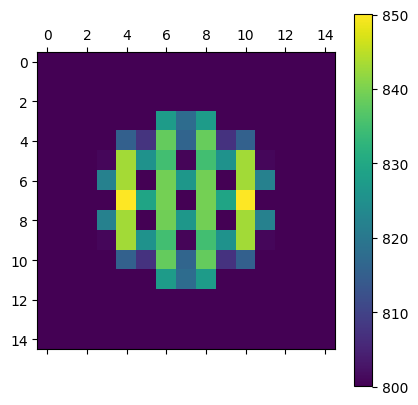

In [5]:
from matplotlib import pyplot as plt 

Tdist_input = fs_tallies * (745 - 600) + 600

plt.matshow(db.database_teperature_profiles[2])
plt.colorbar()


db.linear_interpolation_non_uniform_T(T_distribution=Tdist_input)

[1.48698463]
[1.48964611 1.48468    1.48103378 1.47665609]


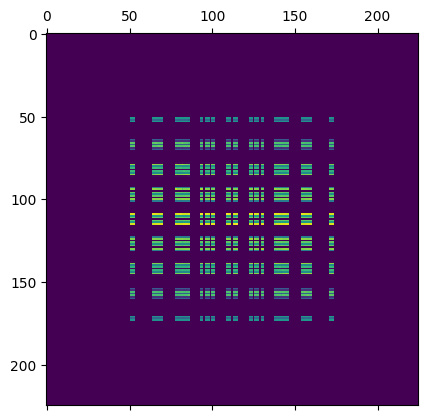

In [8]:
db.fmtx_interpolated
plt.matshow(db.fmtx_interpolated)
print(db.k_fmtx_interpolated)
print(db.k_eig_data_base)

In [9]:
import numpy as np

def select_matrices(matrix_db, matrix_given):
    """
    Seleziona le matrici lower e upper per ogni cella di matrix_given rispetto al database.
    matrix_db: numpy array di dimensione (num_matrices, n, m) (stack di matrici).
    matrix_given: numpy array di dimensione (n, m).
    """
    # Ottieni la dimensione delle matrici
    num_matrices, n, m = matrix_db.shape
    
    # Inizializza le matrici "lower" e "upper"
    lower_matrix = np.zeros((n, m), dtype=int)  # Indice della matrice lower
    upper_matrix = np.zeros((n, m), dtype=int)  # Indice della matrice upper

    for i in range(n):
        for j in range(m):
            given_value = matrix_given[i, j]
            
            # Valori della cella corrente in tutte le matrici
            cell_values = matrix_db[:, i, j]
            
            # Ordina i valori e ottieni gli indici originali
            sorted_indices = np.argsort(cell_values)
            sorted_values = cell_values[sorted_indices]
            
            # Cerca le matrici lower e upper
            for k in range(num_matrices - 1):
                if sorted_values[k] <= given_value < sorted_values[k + 1]:
                    lower_matrix[i, j] = sorted_indices[k] + 1
                    upper_matrix[i, j] = sorted_indices[k + 1] + 1
                    break
            else:
                # Caso con uguaglianze o outlier: espandi la verifica alle celle adiacenti
                lower_matrix[i, j], upper_matrix[i, j] = expand_neighbors(matrix_db, i, j, given_value)
    
    return lower_matrix, upper_matrix



def expand_neighbors(matrix_db, i, j, given_value, max_radius=5):
    """
    Espandi progressivamente il controllo alle celle adiacenti fino a trovare 
    valori distintivi o fino al raggiungimento di un raggio massimo.
    """
    num_matrices, n, m = matrix_db.shape
    radius = 1
    
    while radius <= max_radius:
        neighbors = []
        
        # Esplora tutte le celle nell'anello di raggio `radius`
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                if abs(di) != radius and abs(dj) != radius:  # Escludi le celle non sull'anello
                    continue
                
                ni, nj = i + di, j + dj
                if 0 <= ni < n and 0 <= nj < m:
                    neighbors.append(matrix_db[:, ni, nj])
        
        # Controlla se ci sono valori distintivi nei vicini
        if neighbors:
            neighbors = np.array(neighbors)
            avg_values = np.nanmean(neighbors, axis=0)  # Media per distinguere tra le matrici
            
            # Ordina in base alla distanza media dai valori target
            sorted_indices = np.argsort(avg_values)
            sorted_values = avg_values[sorted_indices]
            
            if given_value > sorted_values[0] and given_value < sorted_values[1]:
                return sorted_indices[0] + 1, sorted_indices[1] + 1
            elif given_value > sorted_values[1] and given_value < sorted_values[2]:
                return sorted_indices[1] + 1, sorted_indices[2] + 1
        
        # Incrementa il raggio per esplorare l'anello successivo
        radius += 1
    
    # Caso limite: se non trovi valori distintivi dopo `max_radius`, usa un valore predefinito
    return 0, 0


# Esempio d'uso

m1 = np.array([[600, 600, 600], [600, 800, 600], [600, 600, 600]])
m2 = np.array([[600, 600, 600], [600, 900, 600], [600, 600, 600]])
m3 = np.array([[600, 600, 600], [600, 1300, 600], [600, 600, 600]])
matrix_db = np.array([m1, m2, m3])

matrix_given = np.array([[600, 600, 600], [600, 1200, 600], [600, 600, 600]])

lower, upper = select_matrices(matrix_db, matrix_given)
print("Lower Matrix Indices:\n", lower)
print("Upper Matrix Indices:\n", upper)
print(matrix_db)
print(matrix_given)



Lower Matrix Indices:
 [[0 0 0]
 [0 2 0]
 [0 0 0]]
Upper Matrix Indices:
 [[0 0 0]
 [0 3 0]
 [0 0 0]]
[[[ 600  600  600]
  [ 600  800  600]
  [ 600  600  600]]

 [[ 600  600  600]
  [ 600  900  600]
  [ 600  600  600]]

 [[ 600  600  600]
  [ 600 1300  600]
  [ 600  600  600]]]
[[ 600  600  600]
 [ 600 1200  600]
 [ 600  600  600]]


In [36]:
import numpy as np

def calculate_ring_difference(matrix1, matrix2, x, y, radius):
    """
    Calcola la differenza degli "anelli" attorno all'elemento selezionato nelle due matrici.

    Args:
        matrix1 (np.ndarray): Prima matrice.
        matrix2 (np.ndarray): Seconda matrice.
        x (int): Coordinata x dell'elemento selezionato.
        y (int): Coordinata y dell'elemento selezionato.
        radius (int): Raggio dell'anello da considerare.

    Returns:
        float: Differenza totale tra gli anelli delle due matrici.
    """
    n_rows, n_cols = matrix1.shape
    difference = 0

    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            # Calcola la distanza di Manhattan per determinare se è nell'anello
            if radius - 1 < max(abs(i), abs(j)) <= radius:
                new_x, new_y = x + i, y + j

                # Controlla che le coordinate siano all'interno dei limiti delle matrici
                if 0 <= new_x < n_rows and 0 <= new_y < n_cols:
                    difference += abs(matrix1[new_x, new_y] - matrix2[new_x, new_y])

    return difference

def find_closest_matrices(input_matrix, database, max_radius):
    """
    Trova, per ogni elemento della matrice di input, le matrici del database con valori subito inferiori e superiori.
    Se ci sono ambiguità, usa la differenza degli anelli circostanti per selezionare la matrice corretta.

    Args:
        input_matrix (np.ndarray): Matrice fornita in input.
        database (list of np.ndarray): Lista di matrici del database.
        max_radius (int): Raggio massimo per il confronto degli anelli.

    Returns:
        tuple: Due liste di matrici selezionate (per valori inferiori e superiori).
    """
    n_rows, n_cols = input_matrix.shape
    lower_closest = np.full((n_rows, n_cols), None, dtype=object)
    upper_closest = np.full((n_rows, n_cols), None, dtype=object)

    for x in range(n_rows):
        for y in range(n_cols):
            value = input_matrix[x, y]
            lower_candidates = []
            upper_candidates = []

            # Trova candidati inferiori e superiori
            for idx, db_matrix in enumerate(database):
                db_value = db_matrix[x, y]
                if db_value <= value:
                    lower_candidates.append((idx, db_value))
                elif db_value >= value:
                    upper_candidates.append((idx, db_value))

            # Seleziona i candidati migliori
            if lower_candidates:
                lower_candidates.sort(key=lambda c: value - c[1])  # Ordina per vicinanza al valore
                best_lower = [c for c in lower_candidates if value - c[1] == value - lower_candidates[0][1]]

                if len(best_lower) > 1:  # Ambiguità, usa gli anelli
                    differences = [
                        (idx, calculate_ring_difference(input_matrix, database[idx], x, y, 1))
                        for idx, _ in best_lower
                    ]
                    differences.sort(key=lambda d: d[1])  # Ordina per differenza minima
                    lower_closest[x, y] = differences[0][0]
                else:
                    lower_closest[x, y] = best_lower[0][0]

            if upper_candidates:
                upper_candidates.sort(key=lambda c: c[1] - value)  # Ordina per vicinanza al valore
                best_upper = [c for c in upper_candidates if c[1] - value == upper_candidates[0][1] - value]

                if len(best_upper) > 1:  # Ambiguità, usa gli anelli
                    differences = [
                        (idx, calculate_ring_difference(input_matrix, database[idx], x, y, 1))
                        for idx, _ in best_upper
                    ]
                    differences.sort(key=lambda d: d[1])  # Ordina per differenza minima
                    upper_closest[x, y] = differences[0][0]
                else:
                    upper_closest[x, y] = best_upper[0][0]

    return lower_closest, upper_closest

if __name__ == "__main__":
    # Matrice di input
    # input_matrix = np.random.randint(0, 6, (6, 6)).astype(float)
    input_matrix = np.array([[0.1,1.1,0.1],[0.1,1.1,0.1],[0.1,1.1,0.1]])
    input_matrix[input_matrix==0.0]= 0.0 +0.01
    input_matrix[input_matrix==5.0]= 5.0 -0.01

    # Database di matrici
    #database = [np.random.randint(0, 6, (6, 6)) for _ in range(5)]
    m1= [[0,0,0],[0,0,0],[0,0,0]]
    m2= [[1,1,1],[1,0,1],[1,1,1]]
    m3= [[2,2,2],[2,2,2],[2,2,2]]        
    
    database = np.array([m1,m2,m3])
    
    max_radius = 3

    print("Database:")
    for db in database:
        print(db,"\n")
    print("\nInput Matrix:")
    print(input_matrix)

    lower, upper = find_closest_matrices(input_matrix, database, max_radius)
    print("\nMatrice dei più vicini inferiori:")
    print(lower)
    print("\nMatrice dei più vicini superiori:")
    print(upper)




Database:
[[0 0 0]
 [0 0 0]
 [0 0 0]] 

[[1 1 1]
 [1 0 1]
 [1 1 1]] 

[[2 2 2]
 [2 2 2]
 [2 2 2]] 


Input Matrix:
[[0.1 1.1 0.1]
 [0.1 1.1 0.1]
 [0.1 1.1 0.1]]

Matrice dei più vicini inferiori:
[[0 1 0]
 [0 0 0]
 [0 1 0]]

Matrice dei più vicini superiori:
[[1 2 1]
 [1 2 1]
 [1 2 1]]


Fission Source Values: [0. 0. 0. ... 0. 0. 0.]
Mesh Dimensions: nz = 1 , nx = 80 , ny = 80


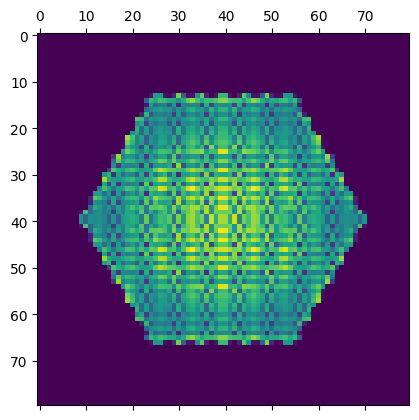

In [49]:
import numpy as np 
def extract_fission_source_and_mesh(file_path, detector_name):
    """
    Legge un file, cerca la variabile DET<detector_name>, estrae i valori della fission source
    e deduce le dimensioni della mesh dai valori massimi delle colonne 8, 9 e 10.

    :param file_path: Percorso al file da leggere.
    :param detector_name: Nome base del detector (es. 'xy_fission_source').
    :return: Tuple (fission_source_values, nz, nx, ny), dove:
             - fission_source_values: lista di valori della fission source (float).
             - nz, nx, ny: dimensioni della mesh dedotte.
    """
    detector_variable = f"DET{detector_name}"  # Variabile da cercare
    reading_data = False
    fission_source_values = []
    z_values = []  # Per dedurre nz
    y_values = []  # Per dedurre ny
    x_values = []  # Per dedurre nx
    
    with open(file_path, 'r') as file:
        for line in file:
            # Controlla se inizia la sezione della variabile detector
            if line.strip().startswith(detector_variable):
                reading_data = True
                continue  # Salta questa riga e inizia a leggere i dati successivi
            
            # Se siamo nella sezione dati, leggi i valori
            if reading_data:
                if line.strip() == "];":  # Fine della variabile detector
                    break
                
                # Salta righe vuote o malformattate
                if not line.strip() or line.strip().startswith("#"):
                    continue
                
                columns = line.split()
                try:
                    # Colonne: 8 (z), 9 (y), 10 (x), 11 (fission source)
                    z = int(columns[7])
                    y = int(columns[8])
                    x = int(columns[9])
                    fission_source = float(columns[10])
                    
                    z_values.append(z)
                    y_values.append(y)
                    x_values.append(x)
                    fission_source_values.append(fission_source)
                except (IndexError, ValueError):
                    continue  # Salta righe mal formattate
    
    # Deduzione delle dimensioni della mesh
    nz = max(z_values) if z_values else 0
    ny = max(y_values) if y_values else 0
    nx = max(x_values) if x_values else 0
    
    if nz == 0 or ny == 0 or nx == 0:
        raise ValueError("Non è stato possibile dedurre le dimensioni della mesh.")
    
    if not fission_source_values:
        raise ValueError(f"Nessun dato trovato per il detector {detector_variable}.")
    
    return np.array(fission_source_values), nz, nx, ny


# Esempio di utilizzo
file_path = r"C:\Users\christian.vita\OneDrive - Politecnico di Torino (1)\MyWork\Fission Matrix\my_tests\eVinci_fullcore\full_core_mesh_grid_test_cases\80x80\geometry_test_ser_det0.m"
fission_values, nz, nx, ny = extract_fission_source_and_mesh(file_path,'xy_fission_source')
print("Fission Source Values:", fission_values)
print("Mesh Dimensions: nz =", nz, ", nx =", nx, ", ny =", ny)

from matplotlib import pyplot as plt

plt.matshow(fission_values.reshape(nx,ny,nz))
